# Определение стоимости автомобилей

**Описание проекта:** Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.  

**Цель проекта:** Построить модель, которая будет определять стоимость машины.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Открытие файла

In [1]:
!pip install category_encoders
!pip install catboost
!pip install lightgbm

In [2]:
import pandas as pd
import warnings
from IPython.core.display import display, HTML
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [3]:
display(HTML("<style>.container { width:85% !important; }</style>"))
warnings.filterwarnings("ignore")
try:# конструкция try - except для надёжности
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [4]:
def inf(data):#функция для вывода информации о датасете
    display(data.head())
    data.info()
    display(data.describe(include='all').T)
    display(data.corr())
    print('Дубликатов:', data.duplicated().sum())
    return data

In [5]:
inf(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Дубликатов: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [6]:
df = df.drop_duplicates()

**Вывод:** Были обнаружены пропуски в столбцах 'VehicleType', 'Gearbox', 'Model', 'FuelType' и 'Repaired'. Также были обнаружены 4 дубликата и вследствии удалены, и также неправильные типы данных в некоторых столбцах. И ещё были обнаружены выбросы, которые надо удалить.

### Предобработка данных

In [7]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])#поменял тип данных на datetime
df['DateCreated'] = pd.to_datetime(df['DateCreated'])

In [8]:
df['Repaired'] = df['Repaired'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')#заменяю пропуски на unknown так как не знаю как в данной ситуации заполнить их,
#но и пропуски нельзя оставлять, так как модели нормально не обучатся

In [9]:
df['VehicleType'] = df.groupby(
        ['Brand', 'Model']
    ).VehicleType.apply(
        lambda x: x.fillna(x.mode()[0])
    )#заполняю пропуски в VehicleType по соответствию в столбцах Brand и Model

In [10]:
df['Gearbox'] = df.groupby(
        ['Brand', 'Model']
    ).Gearbox.apply(
        lambda x: x.fillna(x.mode()[0])
    )#в Gearbox заполняю пропуски также как в VehicleType

In [11]:
df = df.dropna()#остальные пропуски я решил просто удалить так как в противном случае будет слишком 
df.info()#много столбцов где я пропуски заменю на unknown

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        334660 non-null  datetime64[ns]
 1   Price              334660 non-null  int64         
 2   VehicleType        334660 non-null  object        
 3   RegistrationYear   334660 non-null  int64         
 4   Gearbox            334660 non-null  object        
 5   Power              334660 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          334660 non-null  int64         
 8   RegistrationMonth  334660 non-null  int64         
 9   FuelType           334660 non-null  object        
 10  Brand              334660 non-null  object        
 11  Repaired           334660 non-null  object        
 12  DateCreated        334660 non-null  datetime64[ns]
 13  NumberOfPictures   334660 non-null  int64   

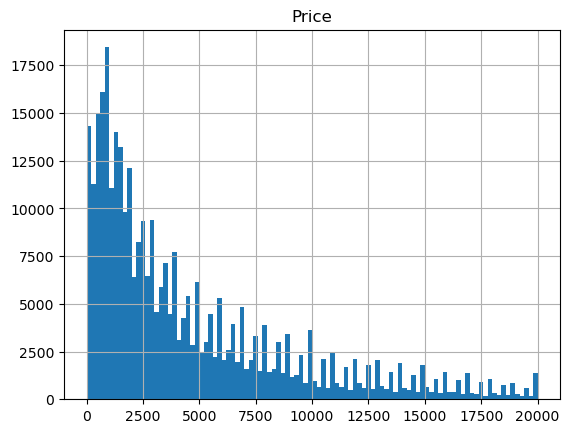

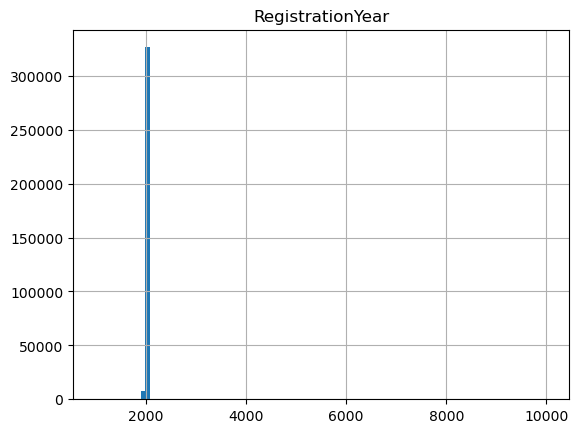

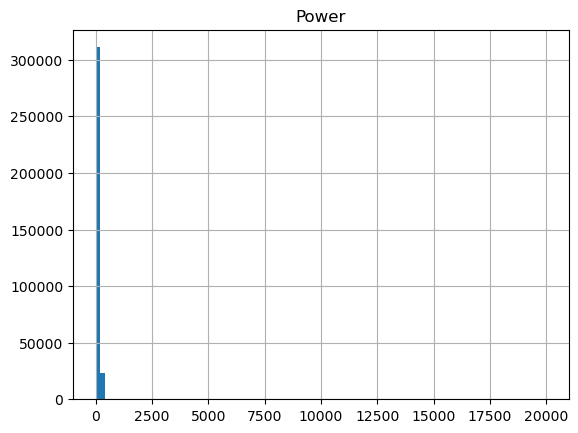

In [12]:
for i in ['Price', 'RegistrationYear', 'Power']:
    df[i].hist(bins=100)
    plt.title(i)
    plt.show()#это для того чтобы увидить выбросы

In [13]:
df = df[df['Price'] > 100]
df = df[df['RegistrationYear'] <= 2016]
df = df[df['Power'] < 1500]#удаляю значения, которые считаю нереальными, такими как RegistrationYear = 9999
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311141 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        311141 non-null  datetime64[ns]
 1   Price              311141 non-null  int64         
 2   VehicleType        311141 non-null  object        
 3   RegistrationYear   311141 non-null  int64         
 4   Gearbox            311141 non-null  object        
 5   Power              311141 non-null  int64         
 6   Model              311141 non-null  object        
 7   Kilometer          311141 non-null  int64         
 8   RegistrationMonth  311141 non-null  int64         
 9   FuelType           311141 non-null  object        
 10  Brand              311141 non-null  object        
 11  Repaired           311141 non-null  object        
 12  DateCreated        311141 non-null  datetime64[ns]
 13  NumberOfPictures   311141 non-null  int64   

**Вывод:** В ходе предобработки были заполнены пропуски там где это возможно сделать качественно, в остальных же местах пропуски были по просту удалены. Также были удалены выбросы в столбцах Price, RegistrationYear и Power. Теперь данные готовы для их разбиения на выборки и обучения моделей.

## Обучение моделей

In [14]:
features = df.drop(['Price', 'DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated'], axis=1)
target = df['Price']#убрал из features все ненужные столбцы

In [15]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=1)

In [16]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [17]:
obj = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder = ce.TargetEncoder(cols=obj)#использовал TargetEncoder так как другие энкодеры не хотели работать
encoder.fit(features_train, target_train)
features_train = encoder.transform(features_train)
features_test = encoder.transform(features_test)

### Случайный лес

In [18]:
%%time
#для измерения времени выполнения кода здесь и в последующих ячейках
model_rf = RandomForestRegressor(random_state=12)
parameters = {'max_depth': [i for i in range(1, 11, 2)],
              'n_estimators': [i for i in range(20, 100, 20)],
              'min_samples_leaf': [i for i in range(1, 10, 2)]
             }
#обучение моделей при помощи GridSearchCV
grid_rf = GridSearchCV(model_rf,
                              parameters,
                              cv=3,
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1
                              )
grid_rf.fit(features_train, target_train)

print('Лучшие параметры:', grid_rf.best_params_)
print('Лучшее RMSE:', abs(grid_rf.best_score_))

Лучшие параметры: {'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 80}
Лучшее RMSE: 1872.6532526197868
Wall time: 9min 30s


### LGBMRegressor

In [19]:
%%time

model_lgbm = LGBMRegressor(random_state=123)
parameters = {'num_leaves': [i for i in range(10, 51, 10)],
              'max_depth': [i for i in range(1, 11, 2)],
              'n_estimators': [i for i in range(20, 100, 20)]}
grid_lgbm = GridSearchCV(model_lgbm,
                            parameters,
                            cv=3,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1             
                        )
grid_lgbm.fit(features_train, target_train)

print('Лучшие параметры:', grid_lgbm.best_params_)
print('Лучшее RMSE:', abs(grid_lgbm.best_score_))

Лучшие параметры: {'max_depth': 9, 'n_estimators': 80, 'num_leaves': 50}
Лучшее RMSE: 1645.7296274833589
Wall time: 37.1 s


### CatBoostRegressor

In [20]:
%%time

model_cat = CatBoostRegressor(random_state=1234)
parameters = {'max_depth': [i for i in range(1, 11, 2)],
              'n_estimators': [i for i in range(20, 100, 20)]}
grid_cat = GridSearchCV(model_cat,
                            parameters,
                            cv=3,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1             
                        )
grid_cat.fit(features_train, target_train)

print('Лучшие параметры:', grid_cat.best_params_)
print('Лучшее RMSE:', abs(grid_cat.best_score_))

Learning rate set to 0.5
0:	learn: 3084.3608995	total: 152ms	remaining: 12s
1:	learn: 2373.3162017	total: 171ms	remaining: 6.66s
2:	learn: 2083.2156659	total: 194ms	remaining: 4.98s
3:	learn: 1953.9659126	total: 219ms	remaining: 4.16s
4:	learn: 1882.2900696	total: 242ms	remaining: 3.63s
5:	learn: 1844.4813340	total: 264ms	remaining: 3.25s
6:	learn: 1816.6903019	total: 285ms	remaining: 2.97s
7:	learn: 1795.4822852	total: 308ms	remaining: 2.77s
8:	learn: 1772.5889061	total: 330ms	remaining: 2.6s
9:	learn: 1756.6583065	total: 355ms	remaining: 2.48s
10:	learn: 1745.3647197	total: 378ms	remaining: 2.37s
11:	learn: 1733.7577963	total: 401ms	remaining: 2.27s
12:	learn: 1724.5642654	total: 428ms	remaining: 2.2s
13:	learn: 1714.3552102	total: 452ms	remaining: 2.13s
14:	learn: 1705.9381063	total: 475ms	remaining: 2.06s
15:	learn: 1696.8276469	total: 496ms	remaining: 1.98s
16:	learn: 1688.6424357	total: 520ms	remaining: 1.93s
17:	learn: 1682.4117574	total: 543ms	remaining: 1.87s
18:	learn: 1673.5

**Вывод:** В данном случае у CatBoostRegressor и наименьшее время среди всех моделей, и лучший RMSE, совсем чуть-чуть ей уступает LGBMRegressor, и соответствено на последнем месте RandomForestRegressor.

## Анализ моделей

In [21]:
%%time

model_r = RandomForestRegressor(random_state=12, max_depth=9, min_samples_leaf=1, n_estimators=80)
model_r.fit(features_train, target_train)

Wall time: 20.9 s


RandomForestRegressor(max_depth=9, n_estimators=80, random_state=12)

In [22]:
%%time

model_r.predict(features_train)

Wall time: 1.14 s


array([11120.23852572, 15083.828815  ,  6324.89567865, ...,
        1254.29094459,  1976.37428011,  2441.43886626])

In [23]:
%%time

model_l = LGBMRegressor(random_state=123, max_depth=9, num_leaves=50, n_estimators=80)
model_l.fit(features_train, target_train)

Wall time: 412 ms


LGBMRegressor(max_depth=9, n_estimators=80, num_leaves=50, random_state=123)

In [24]:
%%time

model_l.predict(features_train)

Wall time: 154 ms


array([ 9824.19804668, 14900.40011217,  6431.66215444, ...,
        1100.05723806,  1656.32616304,  2684.9791253 ])

In [25]:
%%time

model_c = CatBoostRegressor(random_state=1234, max_depth=9, n_estimators=80)
model_c.fit(features_train, target_train)

Learning rate set to 0.5
0:	learn: 3084.3608995	total: 20.5ms	remaining: 1.62s
1:	learn: 2373.3162017	total: 38.4ms	remaining: 1.5s
2:	learn: 2083.2156659	total: 59.7ms	remaining: 1.53s
3:	learn: 1953.9659126	total: 80.6ms	remaining: 1.53s
4:	learn: 1882.2900696	total: 101ms	remaining: 1.52s
5:	learn: 1844.4813340	total: 121ms	remaining: 1.5s
6:	learn: 1816.6903019	total: 143ms	remaining: 1.49s
7:	learn: 1795.4822852	total: 165ms	remaining: 1.48s
8:	learn: 1772.5889061	total: 185ms	remaining: 1.46s
9:	learn: 1756.6583065	total: 209ms	remaining: 1.46s
10:	learn: 1745.3647197	total: 230ms	remaining: 1.44s
11:	learn: 1733.7577963	total: 250ms	remaining: 1.41s
12:	learn: 1724.5642654	total: 271ms	remaining: 1.4s
13:	learn: 1714.3552102	total: 296ms	remaining: 1.39s
14:	learn: 1705.9381063	total: 318ms	remaining: 1.38s
15:	learn: 1696.8276469	total: 337ms	remaining: 1.35s
16:	learn: 1688.6424357	total: 361ms	remaining: 1.34s
17:	learn: 1682.4117574	total: 384ms	remaining: 1.32s
18:	learn: 1

In [26]:
%%time

model_c.predict(features_train)

Wall time: 42 ms


array([10688.70247238, 14675.92789037,  6807.01429985, ...,
        1016.96865036,  1852.2886768 ,  2849.62007424])

In [29]:
comparison = pd.DataFrame(columns=['RMSE модели', 'Время обучения, сек', 'Время предсказания, сек'],
                          index=['RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'])
comparison['RMSE модели'] = 1872.7, 1645.7, 1604.3 
comparison['Время обучения, сек'] = 20.9, 0.4, 1.98
comparison['Время предсказания, сек'] = 1.14, 0.2, 0.04
comparison

,RMSE модели,"Время обучения, сек","Время предсказания, сек"
RandomForestRegressor,1872.7,20.90,1.14
LGBMRegressor,1645.7,0.40,0.20
CatBoostRegressor,1604.3,1.98,0.04


**Вывод:** По RMSE лучшей моделью является CatBoostRegressor обходя LGBMRegressor всего на 41.4 пункта, по времени обучения её обходит LGBMRegressor т. к. время обучения у неё почти в 5 раз меньше, по времени предсказания лучше всех снова CatBoostRegressor, у которой время предсказания в 5 раз меньше, чем у LGBMRegressor. И исходя из всех этих показателей мне кажется, что лучшей моделью является LGBMRegressor т. к. по RMSE она всего на чуть-чуть уступает CatBoostRegressor, и при этом по времени обучения и предсказания обходит его почти в 3.5 раза, что является отличным результатом, а значит именно LGBMRegressor будем пробовать на тестовой выборке.

## Тестирование лучшей модели

In [28]:
model_f = LGBMRegressor(random_state=123, max_depth=9, num_leaves=50, n_estimators=80)
model_f.fit(features_train, target_train)
predict = model_f.predict(features_test)
print('RMSE на тестовой выборке:', np.sqrt(mean_squared_error(target_test, predict)))

RMSE на тестовой выборке: 1633.2503898227842


**Вывод:** LGBMRegressor показал на тестовой выборке RMSE равный 1633, что меньше 2500, то есть задача выполнена, и найдена лучшая модель по соотношению времени обучения и предсказания и метрики RMSE.